In [1]:
import pickle
from pathlib import Path
import pandas as pd

import matplotlib.pyplot as plt
import torch
from neuralhydrology.evaluation.metrics import *
from neuralhydrology.evaluation.evaluate import ESDL_start_evaluation
from neuralhydrology.nh_run import start_run, eval_run, finetune, ESDL_eval_run_test_period
from neuralhydrology.utils.nh_results_ensemble import create_results_ensemble
from neuralhydrology.evaluation.metrics import calculate_metrics
import xarray as x

### Single run

In [2]:
config_path = "../initial_exploration/1_basin.yml"
start_run(config_file=Path(config_path), gpu=-1)

2024-02-26 16:15:20,343: Logging to /Users/evanrobert/Documents/ESDL_Research/ESDL_LSTM/neuralhydrology/runs/discontinuous_train_test_2602_161520/output.log initialized.
2024-02-26 16:15:20,343: ### Folder structure created at /Users/evanrobert/Documents/ESDL_Research/ESDL_LSTM/neuralhydrology/runs/discontinuous_train_test_2602_161520
2024-02-26 16:15:20,344: ### Run configurations for discontinuous_train_test
2024-02-26 16:15:20,344: experiment_name: discontinuous_train_test
2024-02-26 16:15:20,344: train_basin_file: ../initial_exploration/exploration_tuler
2024-02-26 16:15:20,345: validation_basin_file: ../initial_exploration/exploration_tuler
2024-02-26 16:15:20,345: test_basin_file: ../initial_exploration/exploration_tuler
2024-02-26 16:15:20,346: train_start_date: 1981-10-01 00:00:00
2024-02-26 16:15:20,347: train_end_date: 1997-09-30 00:00:00
2024-02-26 16:15:20,347: validation_start_date: 1997-10-01 00:00:00
2024-02-26 16:15:20,348: validation_end_date: 2000-09-30 00:00:00
2024-

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb0a25544c0>
Traceback (most recent call last):
  File "/Users/evanrobert/anaconda3/envs/lstm/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/Users/evanrobert/anaconda3/envs/lstm/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/evanrobert/anaconda3/envs/lstm/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/Users/evanrobert/anaconda3/envs/lstm/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/Users/evanrobert/anaconda3/envs/lstm/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/Users/evanrobert/anaconda3/envs/lstm/lib/python3.10/selectors.py", lin

# Epoch 2:  14%|█▎        | 3/22 [00:37<04:00, 12.64s/it, Loss: 0.0449]


KeyboardInterrupt: 

In [2]:
# change directory to directory specified by output of above cell

run_dir = Path("/Users/evanrobert/Documents/ESDL_Research/ESDL_LSTM/neuralhydrology/runs/ensemble_run_365_2202_024335")
eval_run(run_dir=run_dir, period="test")

# Evaluation: 100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


Load and inspect model predictions

In [3]:
with open(run_dir / "test" / "model_epoch032" / "test_results.p", "rb") as fp:
    results = pickle.load(fp)
    
results['Tuler']['1D']['xr']

<xarray.Dataset>
Dimensions:                           (date: 1826, time_step: 1)
Coordinates:
  * date                              (date) datetime64[ns] 2000-10-01 ... 20...
  * time_step                         (time_step) int64 0
Data variables:
    ReservoirInflowFLOW-OBSERVED_obs  (date, time_step) float32 6.8 7.9 ... 20.1
    ReservoirInflowFLOW-OBSERVED_sim  (date, time_step) float32 12.2 ... 19.02

In [4]:
#get output from physical model to plot with LSTM output

df = pd.read_csv('/Users/evanrobert/Documents/ESDL_Research/Training_Data_3_Basins/HMS_inflow_results_data.csv')

physical_data = df[['Date', 'ReservoirInflowFLOW']]
physical_data["Date"] = pd.to_datetime(physical_data["Date"])


# test_start_date: "01/10/2000"
# test_end_date: "30/09/2005"

start_date = '2000-10-01'
end_date = '2005-09-30'

# Filter the DataFrame to keep only the dates within the specified range
physical_data = physical_data[(physical_data['Date'] >= start_date) & (physical_data['Date'] <= end_date)]

/var/folders/93/12rdf89j3ql6h5j8b_3g9ddm0000gn/T/ipykernel_57414/2986311312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  physical_data["Date"] = pd.to_datetime(physical_data["Date"])


Text(0.5, 1.0, 'Test period - NSE 0.662')

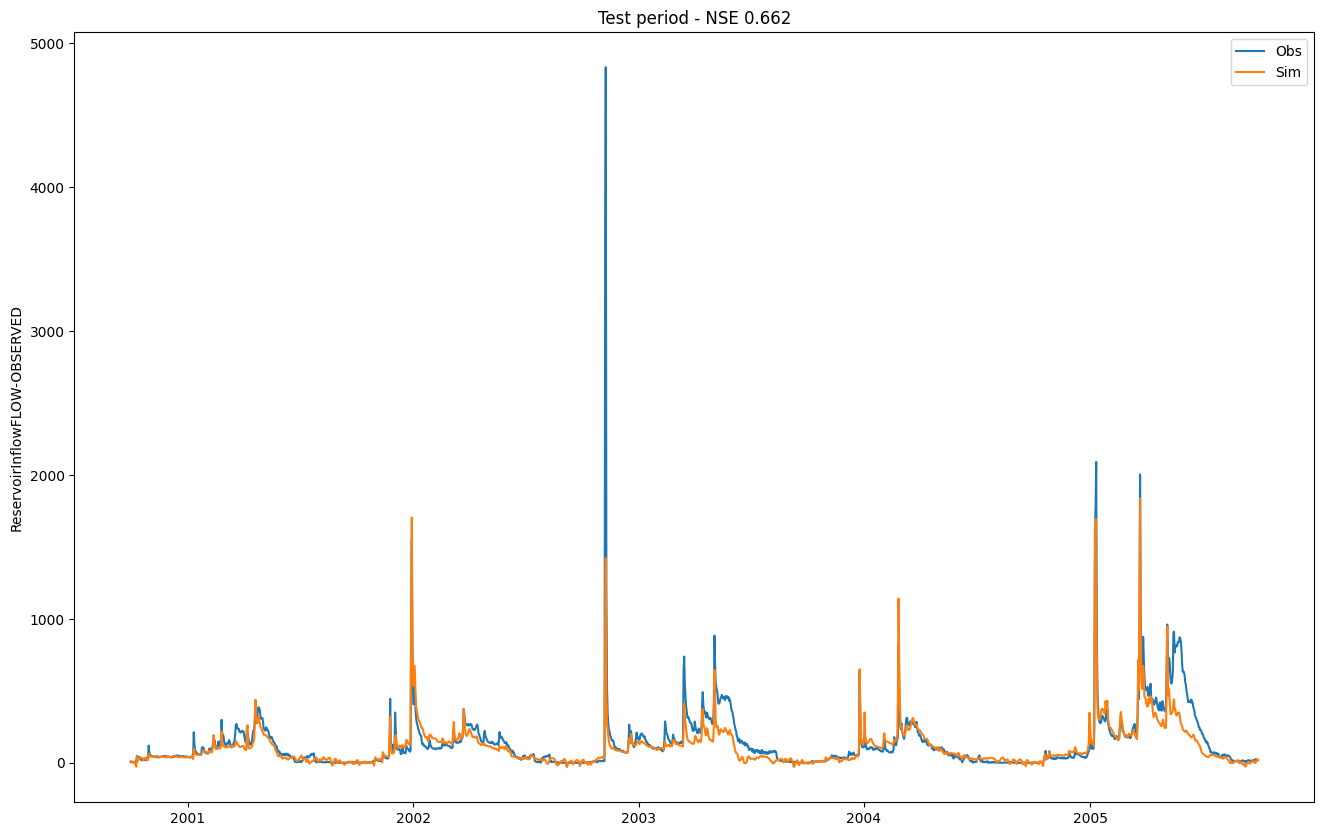

In [5]:
# # extract observations and LSTM simulations
# qobs = results['Tuler']['1D']['xr']['ReservoirInflowFLOW-OBSERVED_obs']
# qsim = results['Tuler']['1D']['xr']['ReservoirInflowFLOW-OBSERVED_sim']

# fig, ax = plt.subplots(figsize=(16,10))
# ax.plot(physical_data["Date"], qobs, label = "observed")
# ax.plot(physical_data["Date"], physical_data['ReservoirInflowFLOW'], label= "physical model")
# ax.plot(physical_data["Date"], qsim, label = "LSTM")
# ax.set_ylabel("ReservoirInflowFLOW-OBSERVED")
# ax.set_title(f"Test period - NSE {results['Tuler']['1D']['NSE']:.3f}")
# ax.legend()
# plt.show()

# extract observations and LSTM simulations
qobs = results['Tuler']['1D']['xr']['ReservoirInflowFLOW-OBSERVED_obs']
qsim = results['Tuler']['1D']['xr']['ReservoirInflowFLOW-OBSERVED_sim']

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(qobs["date"], qobs, label="Obs")
ax.plot(qsim["date"], qsim, label="Sim")
ax.set_ylabel("ReservoirInflowFLOW-OBSERVED")
ax.legend()
ax.set_title(f"Test period - NSE {results['Tuler']['1D']['NSE']:.3f}")

### Ensemble Run

In [3]:
start_run(config_file=Path("../initial_exploration/1_basin.yml"), gpu=-1)

2024-02-22 19:40:15,663: Logging to /Users/evanrobert/Documents/ESDL_Research/ESDL_LSTM/neuralhydrology/runs/ensemble_run_365_2202_194015/output.log initialized.
2024-02-22 19:40:15,664: ### Folder structure created at /Users/evanrobert/Documents/ESDL_Research/ESDL_LSTM/neuralhydrology/runs/ensemble_run_365_2202_194015
2024-02-22 19:40:15,665: ### Run configurations for ensemble_run_365
2024-02-22 19:40:15,666: experiment_name: ensemble_run_365
2024-02-22 19:40:15,667: train_basin_file: ../initial_exploration/exploration_tuler
2024-02-22 19:40:15,668: validation_basin_file: ../initial_exploration/exploration_tuler
2024-02-22 19:40:15,669: test_basin_file: ../initial_exploration/exploration_tuler
2024-02-22 19:40:15,673: train_start_date: 1982-10-01 00:00:00
2024-02-22 19:40:15,675: train_end_date: 1997-09-30 00:00:00
2024-02-22 19:40:15,677: validation_start_date: 1997-10-01 00:00:00
2024-02-22 19:40:15,678: validation_end_date: 2000-09-30 00:00:00
2024-02-22 19:40:15,679: test_start_d

In [14]:
import warnings

#warnings.filterwarnings("ignore", message="Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.")

num_ensemble_members = 8
config_path = "../initial_exploration/1_basin.yml"
for i in range(num_ensemble_members):
    start_run(config_file=Path(config_path), gpu=-1)


2024-02-22 02:11:27,746: Logging to /Users/evanrobert/Documents/ESDL_Research/ESDL_LSTM/neuralhydrology/runs/ensemble_run2_2202_021127/output.log initialized.
2024-02-22 02:11:27,749: ### Folder structure created at /Users/evanrobert/Documents/ESDL_Research/ESDL_LSTM/neuralhydrology/runs/ensemble_run2_2202_021127
2024-02-22 02:11:27,749: ### Run configurations for ensemble_run2
2024-02-22 02:11:27,750: experiment_name: ensemble_run2
2024-02-22 02:11:27,750: train_basin_file: ../initial_exploration/exploration_tuler
2024-02-22 02:11:27,750: validation_basin_file: ../initial_exploration/exploration_tuler
2024-02-22 02:11:27,751: test_basin_file: ../initial_exploration/exploration_tuler
2024-02-22 02:11:27,751: train_start_date: 1982-10-01 00:00:00
2024-02-22 02:11:27,752: train_end_date: 1997-09-30 00:00:00
2024-02-22 02:11:27,752: validation_start_date: 1997-10-01 00:00:00
2024-02-22 02:11:27,753: validation_end_date: 2000-09-30 00:00:00
2024-02-22 02:11:27,753: test_start_date: 2000-10

In [2]:
#collect run directories
#TODO automate this

ensemble_runs = [Path('/Users/evanrobert/Documents/ESDL_Research/ESDL_LSTM/neuralhydrology/runs/ensemble_run_365_2202_024335'), 
Path('/Users/evanrobert/Documents/ESDL_Research/ESDL_LSTM/neuralhydrology/runs/ensemble_run_365_2202_120528'),
Path('/Users/evanrobert/Documents/ESDL_Research/ESDL_LSTM/neuralhydrology/runs/ensemble_run_365_2202_121917'),
Path('/Users/evanrobert/Documents/ESDL_Research/ESDL_LSTM/neuralhydrology/runs/ensemble_run_365_2202_123346'),
Path('/Users/evanrobert/Documents/ESDL_Research/ESDL_LSTM/neuralhydrology/runs/ensemble_run_365_2202_124719'),
Path('/Users/evanrobert/Documents/ESDL_Research/ESDL_LSTM/neuralhydrology/runs/ensemble_run_365_2202_134044'),
Path('/Users/evanrobert/Documents/ESDL_Research/ESDL_LSTM/neuralhydrology/runs/ensemble_run_365_2202_194015')
]
for run in ensemble_runs:
    eval_run(run_dir=run, period="test")
    eval_run(run_dir=run, period="validation")

# Validation: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


In [3]:
ensemble_run = create_results_ensemble(ensemble_runs, period='test')

Loading results for each run.


100%|██████████| 7/7 [00:00<00:00, 746.34it/s]


Combining results and calculating metrics.


100%|██████████| 1/1 [00:00<00:00, 93.94it/s]


Text(0.5, 1.0, 'Test period - NSE 0.655')

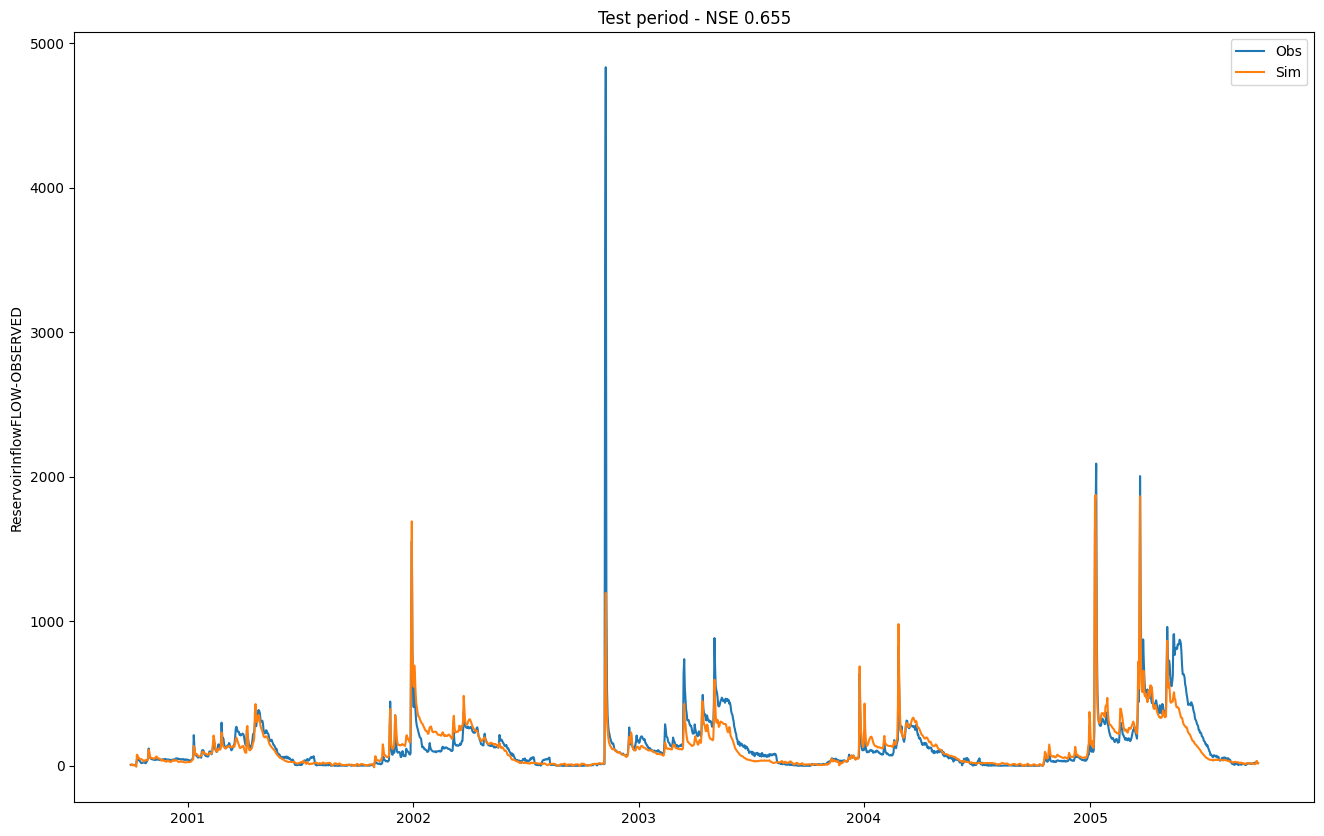

In [4]:
# extract observations and LSTM simulations
qobs = ensemble_run['Tuler']['1D']['xr']['ReservoirInflowFLOW-OBSERVED_obs']
qsim = ensemble_run['Tuler']['1D']['xr']['ReservoirInflowFLOW-OBSERVED_sim']

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(qobs["datetime"], qobs, label="Obs")
ax.plot(qsim["datetime"], qsim, label="Sim")
ax.set_ylabel("ReservoirInflowFLOW-OBSERVED")
ax.legend()
ax.set_title(f"Test period - NSE {ensemble_run['Tuler']['1D']['NSE']:.3f}")

In [14]:
#see all model errors
for run in ensemble_runs:
    with open(run / "test" / "model_epoch032" / "test_results.p", "rb") as fp:
        results = pickle.load(fp)
        print(f"{results['Tuler']['1D']['NSE']:.3f}")

0.662
0.661
0.574
0.682
0.596
0.552
0.667


In [6]:
#get output from physical model to plot with LSTM output

df = pd.read_csv('/Users/evanrobert/Documents/ESDL_Research/Training_Data_3_Basins/HMS_inflow_results_data.csv')

physical_data = df[['Date', 'ReservoirInflowFLOW']]
physical_data["Date"] = pd.to_datetime(physical_data["Date"])


# test_start_date: "01/10/2000"
# test_end_date: "30/09/2005"

start_date = '2000-10-01'
end_date = '2005-09-30'

# Filter the DataFrame to keep only the dates within the specified range
physical_data = physical_data[(physical_data['Date'] >= start_date) & (physical_data['Date'] <= end_date)]

/var/folders/93/12rdf89j3ql6h5j8b_3g9ddm0000gn/T/ipykernel_8956/2986311312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  physical_data["Date"] = pd.to_datetime(physical_data["Date"])


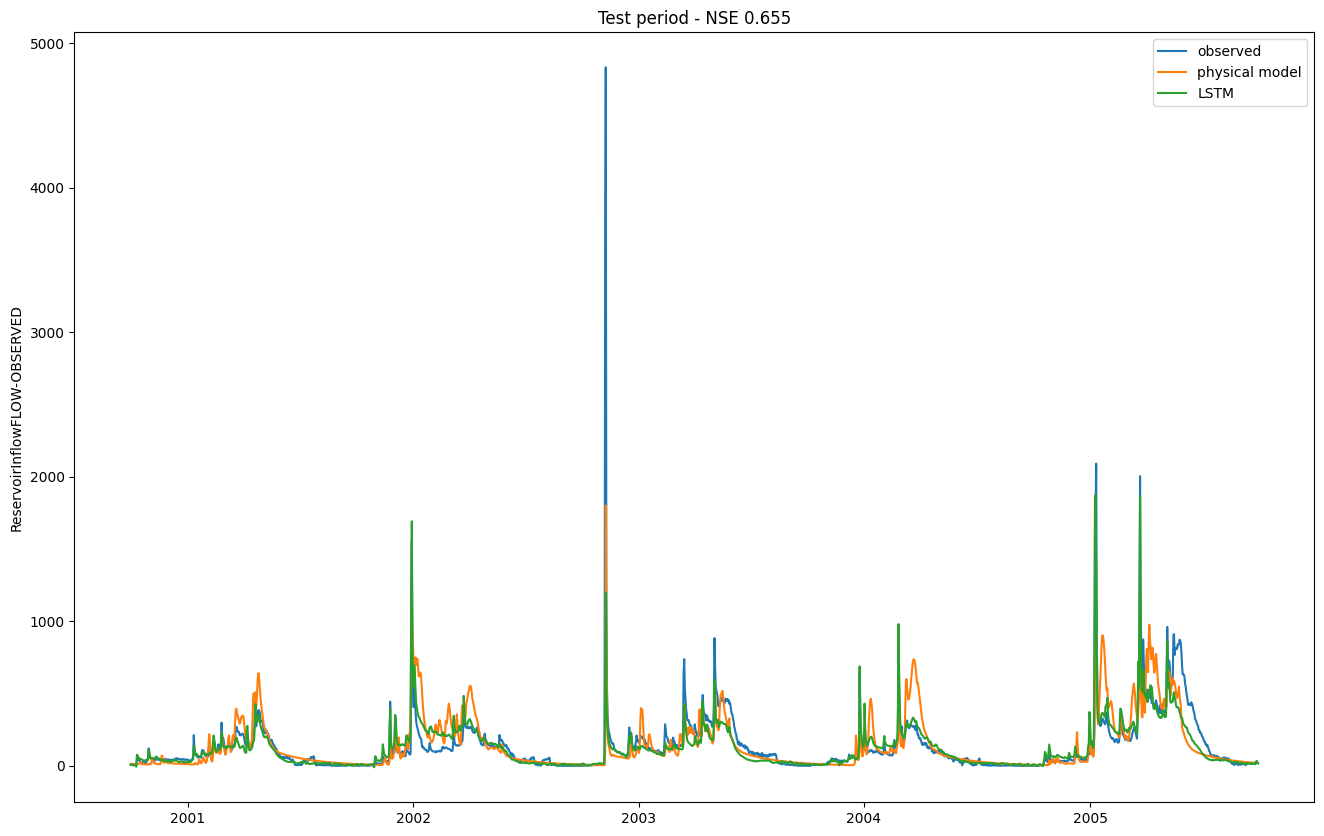

In [8]:
# extract observations and LSTM simulations
qobs = ensemble_run['Tuler']['1D']['xr']['ReservoirInflowFLOW-OBSERVED_obs']
qsim = ensemble_run['Tuler']['1D']['xr']['ReservoirInflowFLOW-OBSERVED_sim']

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(physical_data["Date"], qobs, label = "observed")
ax.plot(physical_data["Date"], physical_data['ReservoirInflowFLOW'], label= "physical model")
ax.plot(physical_data["Date"], qsim, label = "LSTM")
ax.set_ylabel("ReservoirInflowFLOW-OBSERVED")
ax.set_title(f"Test period - NSE {ensemble_run['Tuler']['1D']['NSE']:.3f}")
ax.legend()
plt.show()

### Matlab vs NeuralHydrology predictions

In [30]:
#get matlab lstm predictions from Dino's csv

matlab_lstm = pd.read_csv('/Users/evanrobert/Documents/ESDL_Research/Training_Data_3_Basins/Dino_MatlabLSTM_testresults.csv')
matlab_lstm["Date"] = pd.to_datetime(matlab_lstm["DateTime"])
matlab_lstm = matlab_lstm[['Date', 'LSTM-HMS']]

start_date = '2000-10-01'
end_date = '2005-09-30'

# Filter the DataFrame to keep only the dates within the specified range
matlab_lstm = matlab_lstm[(matlab_lstm['Date'] >= start_date) & (matlab_lstm['Date'] <= end_date)]

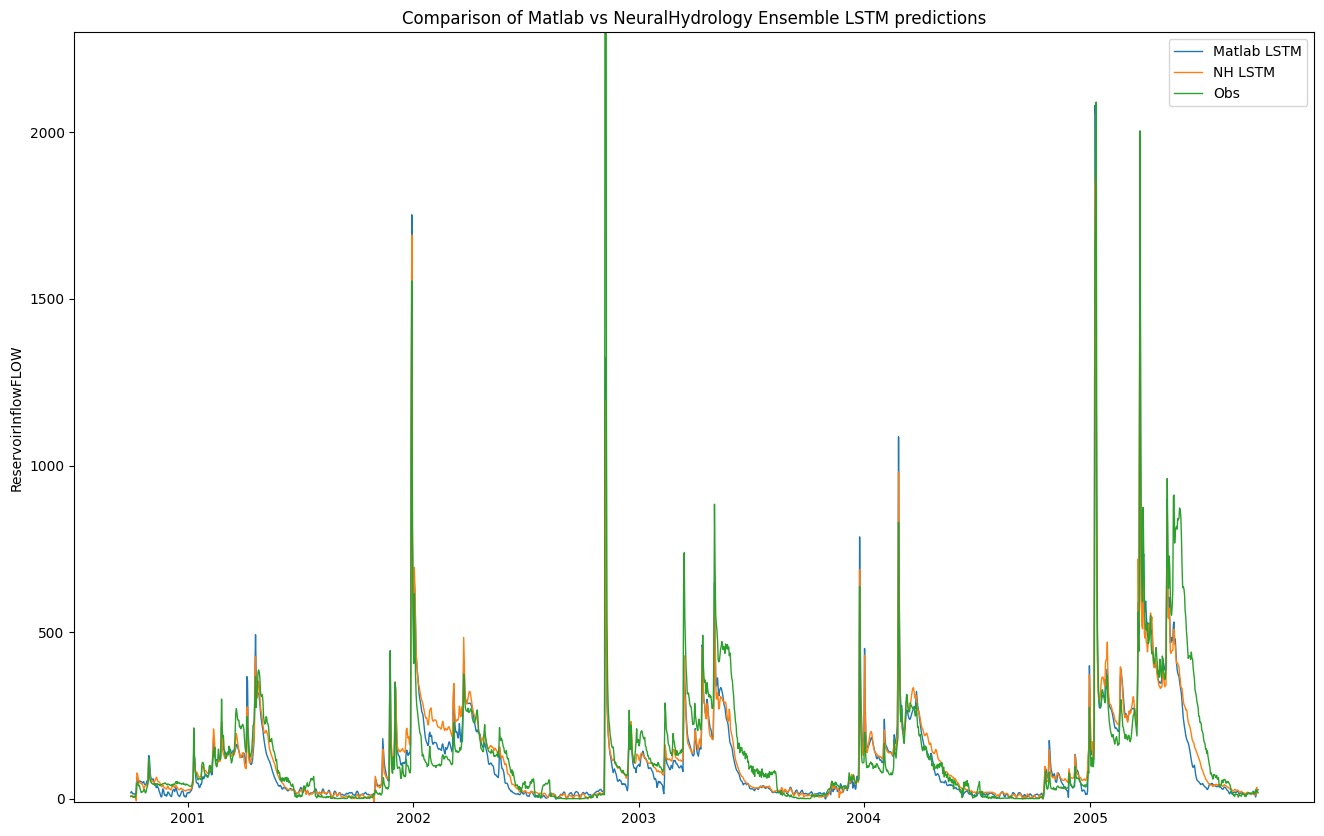

In [67]:
# ensemble run predictions
qobs = ensemble_run['Tuler']['1D']['xr']['ReservoirInflowFLOW-OBSERVED_obs']
qsim = ensemble_run['Tuler']['1D']['xr']['ReservoirInflowFLOW-OBSERVED_sim']

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(matlab_lstm['Date'], matlab_lstm["LSTM-HMS"], label="Matlab LSTM", alpha=1, color='#1f77b4', lw=1)
ax.plot(qsim["datetime"], qsim, label="NH LSTM", alpha=1, color='#ff7f0e', lw=1)
ax.plot(qobs["datetime"], qobs, label="Obs", alpha=1, color='#2ca02c', lw=1)

ax.set_ylim((-10, 2300))

ax.set_ylabel("ReservoirInflowFLOW")
ax.set_title(f"Comparison of Matlab vs NeuralHydrology Ensemble LSTM predictions")
ax.legend()

### Discontinuous train/test

In [ ]:
# get train_start_date, train_end_date, test_start_date, test_end_date
# for config file given list of water years

train_years = [1982,1984,1985,1986,1987,1989,1991,1993,1996,1999,2000,2001,2002,2003,2004,2005]
test_years = [1983,1988,1990,1992,1994,1995,1997,1998]

train_start_dates = ["01/10/" + str(year - 1) for year in train_years]
train_end_dates = ["30/09/" + str(year) for year in train_years]

test_start_dates = ["01/10/" + str(year - 1) for year in test_years]
test_end_dates = ["30/09/" + str(year) for year in test_years]

print(train_start_dates)
print()
print(train_end_dates)
print()
print(test_start_dates)
print()
print(test_end_dates)

In [3]:
config_path = "../initial_exploration/discontinuous_train_test.yml"
start_run(config_file=Path(config_path), gpu=-1)

2024-02-26 16:30:44,169: Logging to /Users/evanrobert/Documents/ESDL_Research/ESDL_LSTM/neuralhydrology/runs/discontinuous_train_test_2602_163044/output.log initialized.
2024-02-26 16:30:44,169: ### Folder structure created at /Users/evanrobert/Documents/ESDL_Research/ESDL_LSTM/neuralhydrology/runs/discontinuous_train_test_2602_163044
2024-02-26 16:30:44,170: ### Run configurations for discontinuous_train_test
2024-02-26 16:30:44,170: experiment_name: discontinuous_train_test
2024-02-26 16:30:44,171: train_basin_file: ../initial_exploration/exploration_tuler
2024-02-26 16:30:44,171: validation_basin_file: ../initial_exploration/exploration_tuler
2024-02-26 16:30:44,171: test_basin_file: ../initial_exploration/exploration_tuler
2024-02-26 16:30:44,173: train_start_date: [Timestamp('1981-10-01 00:00:00'), Timestamp('1983-10-01 00:00:00'), Timestamp('1984-10-01 00:00:00'), Timestamp('1985-10-01 00:00:00'), Timestamp('1986-10-01 00:00:00'), Timestamp('1988-10-01 00:00:00'), Timestamp('1990

#### Train

In [11]:
# change directory to directory specified by output of above cell

run_dir = Path("/Users/evanrobert/Documents/ESDL_Research/ESDL_LSTM/neuralhydrology/runs/discontinuous_train_test_2602_163044")
eval_run(run_dir=run_dir, period="train")

2024-02-26 16:53:36,546: Using the model weights from /Users/evanrobert/Documents/ESDL_Research/ESDL_LSTM/neuralhydrology/runs/discontinuous_train_test_2602_163044/model_epoch012.pt
# Evaluation: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it]
2024-02-26 16:53:38,624: Stored metrics at /Users/evanrobert/Documents/ESDL_Research/ESDL_LSTM/neuralhydrology/runs/discontinuous_train_test_2602_163044/train/model_epoch012/train_metrics.csv
2024-02-26 16:53:38,630: Stored results at /Users/evanrobert/Documents/ESDL_Research/ESDL_LSTM/neuralhydrology/runs/discontinuous_train_test_2602_163044/train/model_epoch012/train_results.p


In [12]:
with open(run_dir / "train" / "model_epoch012" / "train_results.p", "rb") as fp:
    results = pickle.load(fp)
    
results['Tuler']['1D']['xr']

<xarray.Dataset>
Dimensions:                           (date: 8766, time_step: 1)
Coordinates:
  * date                              (date) datetime64[ns] 1981-10-01 ... 20...
  * time_step                         (time_step) int64 0
Data variables:
    ReservoirInflowFLOW-OBSERVED_obs  (date, time_step) float32 16.2 ... 20.1
    ReservoirInflowFLOW-OBSERVED_sim  (date, time_step) float32 nan ... 32.45

Text(0.5, 1.0, 'Train period - NSE 0.870')

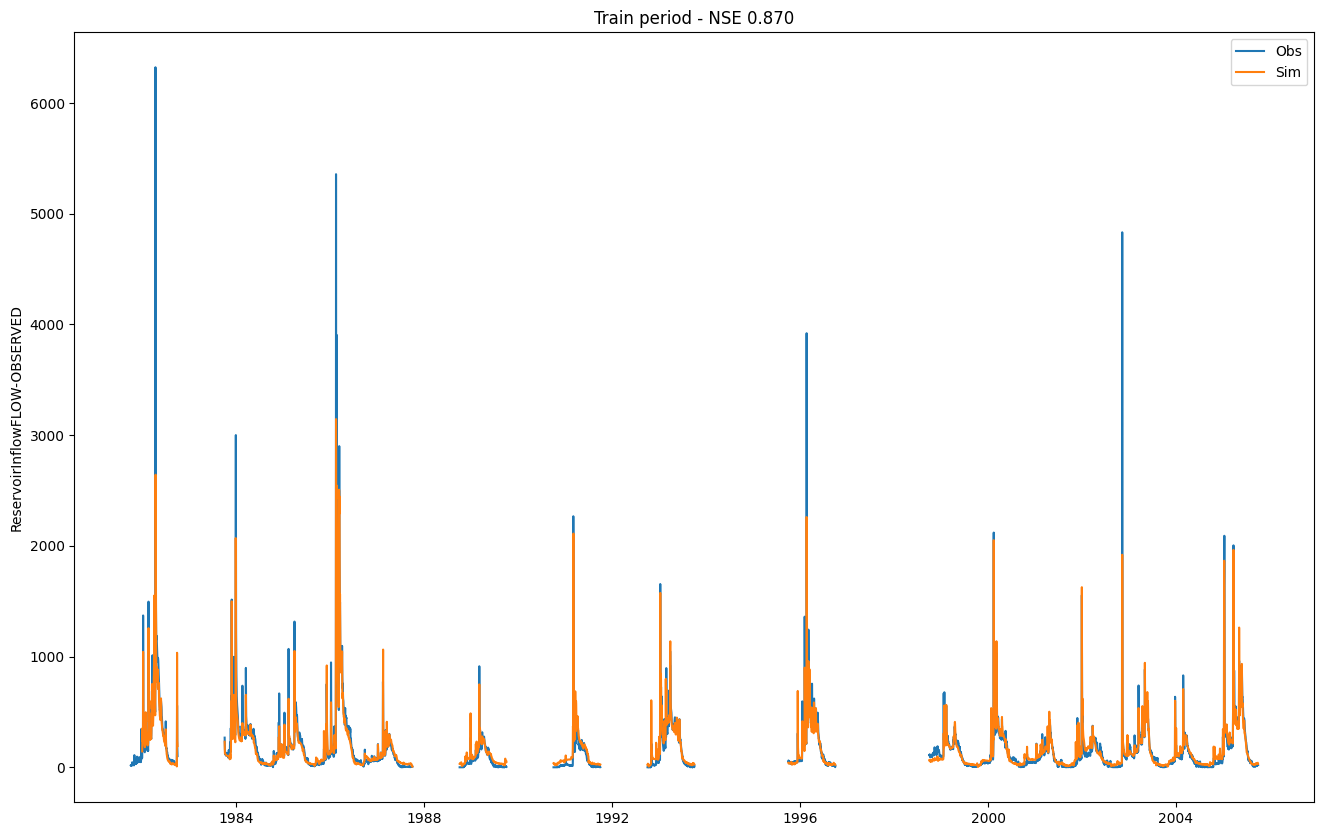

In [17]:
# extract observations and LSTM simulations
qobs = results['Tuler']['1D']['xr']['ReservoirInflowFLOW-OBSERVED_obs']
qsim = results['Tuler']['1D']['xr']['ReservoirInflowFLOW-OBSERVED_sim']

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(qobs["date"], qobs, label="Obs")
ax.plot(qsim["date"], qsim, label="Sim")
ax.set_ylabel("ReservoirInflowFLOW-OBSERVED")
ax.legend()
ax.set_title(f"Train period - NSE {results['Tuler']['1D']['NSE']:.3f}")

#### Test

Discontinuous test dates aren't supported by NH, so this has to be done manually

In [28]:
run_dir = Path("/Users/evanrobert/Documents/ESDL_Research/ESDL_LSTM/neuralhydrology/runs/discontinuous_train_test_2602_163044")

concatonated_dfs, metrics = ESDL_eval_run_test_period(run_dir=run_dir)

# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]


In [29]:
metrics

{'NSE': 0.7431833446025848, 'RMSE': 298.96086961758056}

In [42]:
type((concatonated_dfs['date'].values[0]))

numpy.datetime64

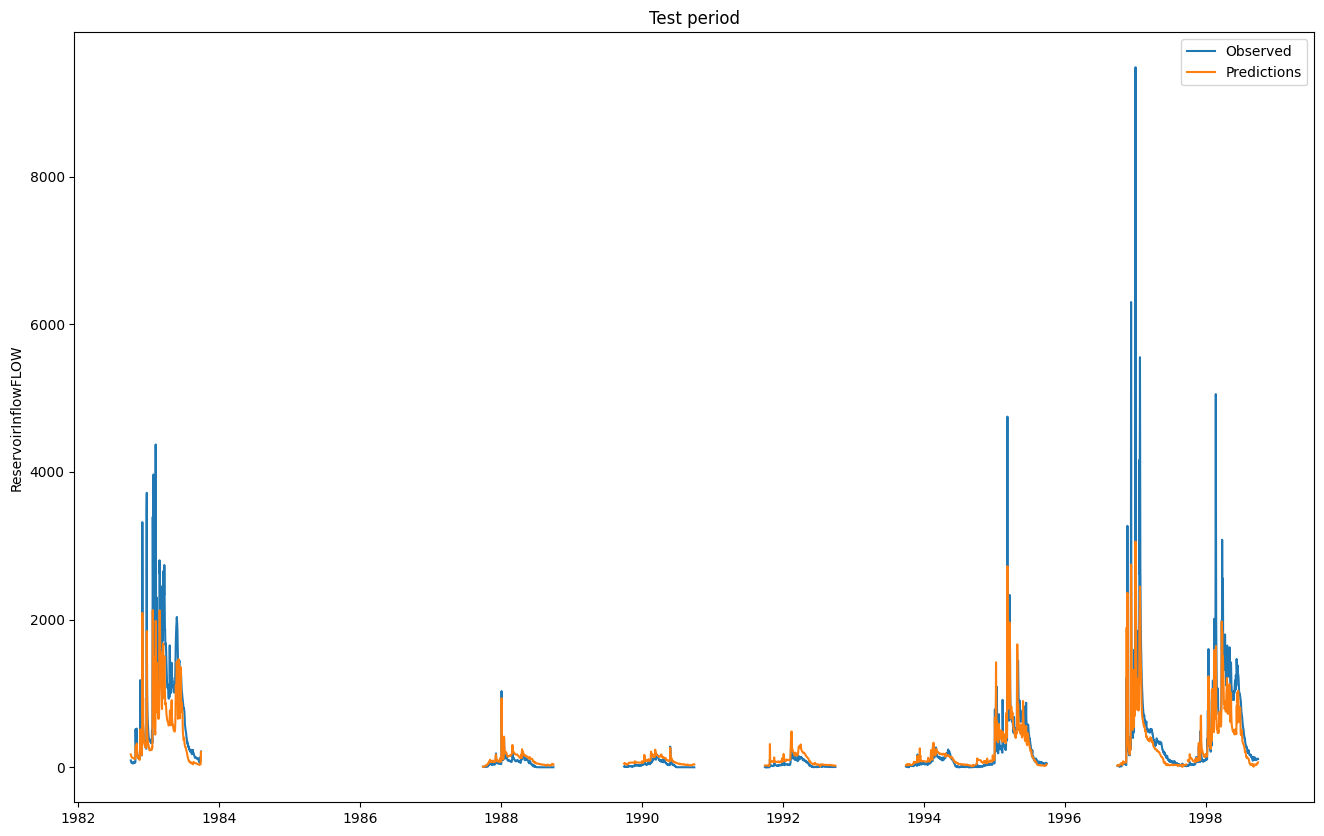

In [30]:
# extract observations and LSTM simulations
num_periods = concatonated_dfs['source'].iloc[-1] + 1

fig, ax = plt.subplots(figsize=(16,10))
for i in range(num_periods):
    period_df = concatonated_dfs[concatonated_dfs['source'] == i]
    obs_label = 'Observed' if i == 0 else None
    predict_label = 'Predictions' if i == 0 else None
    obs_line = ax.plot(period_df['date'], period_df['ReservoirInflowFLOW-OBSERVED_obs'], color='#1f77b4', label = obs_label)
    predicted_line = ax.plot(period_df['date'], period_df['ReservoirInflowFLOW-OBSERVED_sim'], color='#ff7f0e', label = predict_label)

ax.set_ylabel("ReservoirInflowFLOW")
ax.legend()
ax.set_title(f"Test period");

### Presentation plots

In [54]:
def find_splits_daily(path_to_csv):
    
    df = pd.read_csv(path_to_csv)
    df['date'] = pd.to_datetime(df['DateTime'])
    curr_date = None
    
    prev_date = df.at[0, 'date']
    for index, row in df.iterrows():
        curr_date = row['date']
        if (curr_date - prev_date != pd.Timedelta(days=1) and index != 0):
            df.at[index, 'Observed'] = None
            df.at[index, 'HMS'] = None
            df.at[index, 'LSTM_HMS'] = None
        prev_date = curr_date
    return df

In [50]:

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
#find_splits_daily('/Users/evanrobert/Downloads/Inflow_daily_only_test_hard_pelase.csv')


Text(0.5, 1.0, 'Test Periods for Extreme Climate')

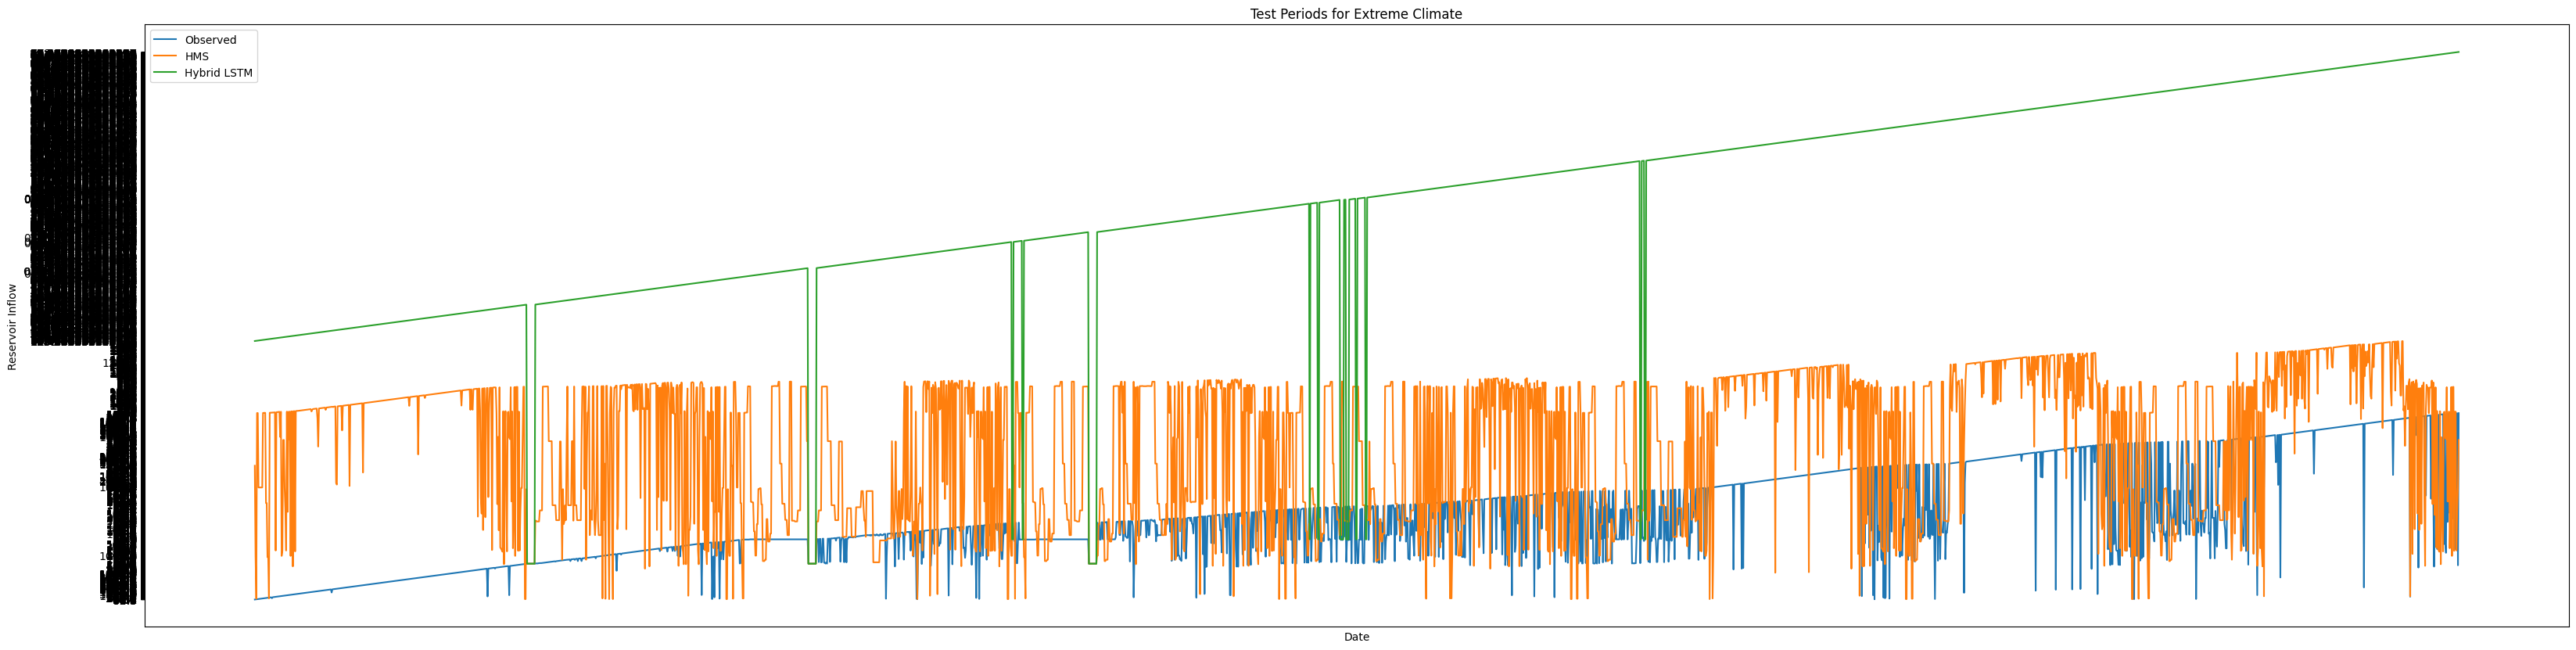

In [56]:
dfs_dfs = pd.read_csv('/Users/evanrobert/Downloads/Inflow_daily_only_test_hard_pelase.csv')


fig, ax = plt.subplots(figsize=(40,10))
ax.plot(dfs_dfs.index, dfs_dfs['Observed'], label="Observed")
ax.plot(dfs_dfs.index, dfs_dfs['HMS'], label="HMS")
ax.plot(dfs_dfs.index, dfs_dfs['LSTM_HMS'], label="Hybrid LSTM")

#ax.set_xticks([])
ax.set_ylabel("Reservoir Inflow")
ax.set_xlabel("Date")
ax.legend()
ax.set_title("Test Periods for Extreme Climate")


In [33]:
def find_splits_monthly(path_to_csv):
    
    df = pd.read_csv(path_to_csv)
    df['date'] = pd.to_datetime(df['DateTime'])
    curr_date = None
    
    prev_date = df.at[0, 'date']
    for index, row in df.iterrows():
        curr_date = row['date']
        if curr_date - prev_date > pd.Timedelta(days=31) and index != 0:
            df.at[index, 'Observed'] = None
            df.at[index, 'HMS'] = None
            df.at[index, 'LSTM_HMS'] = None
        prev_date = curr_date
    return df

Text(0.5, 1.0, 'Test Periods for Extreme Climate')

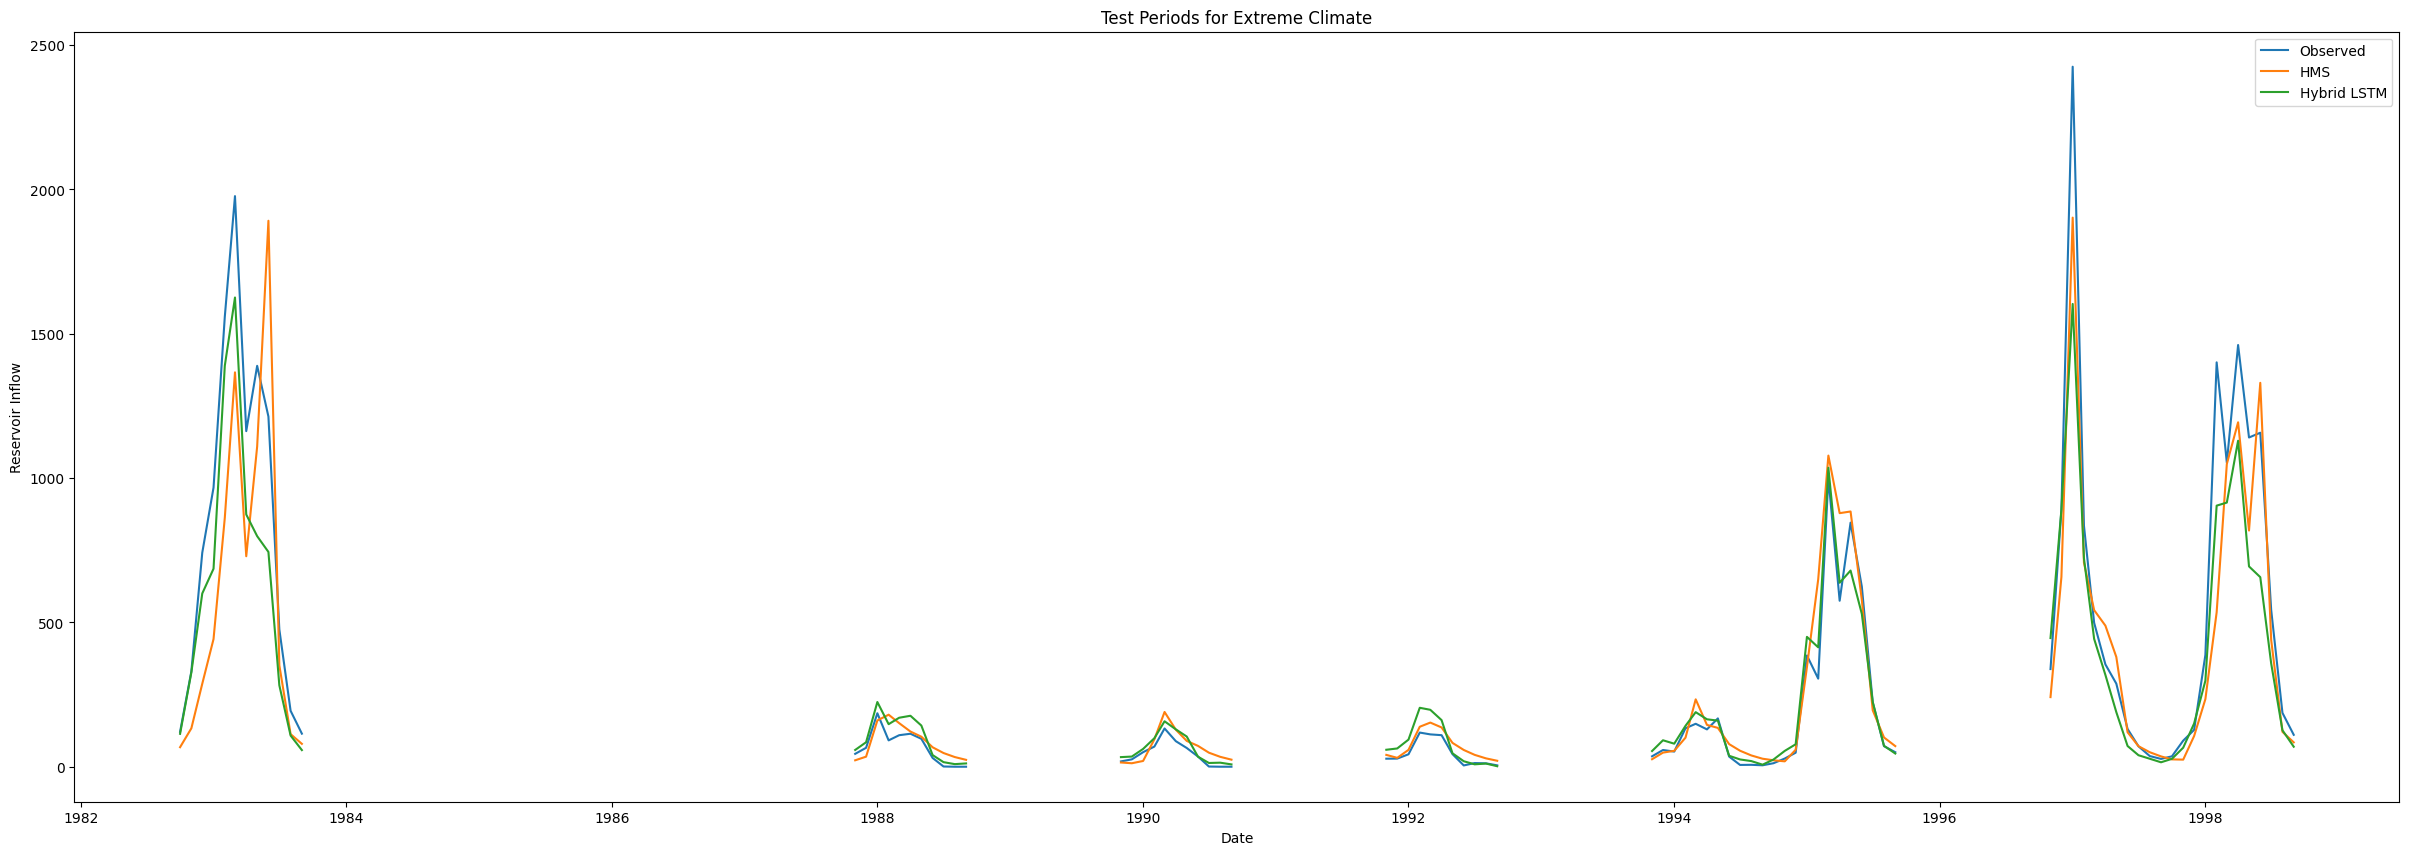

In [34]:
dfs_dfs = find_splits_monthly('/Users/evanrobert/Documents/ESDL_Research/Training_Data_3_Basins/presentation_plot_data/Inflow_monthly_only_test_hard.csv')


fig, ax = plt.subplots(figsize=(30,10))
ax.plot(dfs_dfs["date"], dfs_dfs['Observed'], label="Observed")
ax.plot(dfs_dfs["date"], dfs_dfs['HMS'], label="HMS")
ax.plot(dfs_dfs["date"], dfs_dfs['LSTM_HMS'], label="Hybrid LSTM")

ax.set_ylabel("Reservoir Inflow")
ax.set_xlabel("Date")
ax.legend()
ax.set_title("Test Periods for Extreme Climate")

0      10/01/1982
1      10/02/1982
2      10/03/1982
3      10/04/1982
4      10/05/1982
          ...    
360    09/26/1983
361    09/27/1983
362    09/28/1983
363    09/29/1983
364    09/30/1983
Name: DateTime, Length: 365, dtype: object
365    10/01/1987
366    10/02/1987
367    10/03/1987
368    10/04/1987
369    10/05/1987
          ...    
726    09/26/1988
727    09/27/1988
728    09/28/1988
729    09/29/1988
730    09/30/1988
Name: DateTime, Length: 366, dtype: object
731     10/01/1989
732     10/02/1989
733     10/03/1989
734     10/04/1989
735     10/05/1989
           ...    
1091    09/26/1990
1092    09/27/1990
1093    09/28/1990
1094    09/29/1990
1095    09/30/1990
Name: DateTime, Length: 365, dtype: object
1096    10/01/1991
1097    10/02/1991
1098    10/03/1991
1099    10/04/1991
1100    10/05/1991
           ...    
1457    09/26/1992
1458    09/27/1992
1459    09/28/1992
1460    09/29/1992
1461    09/30/1992
Name: DateTime, Length: 366, dtype: object
1462    10/01/

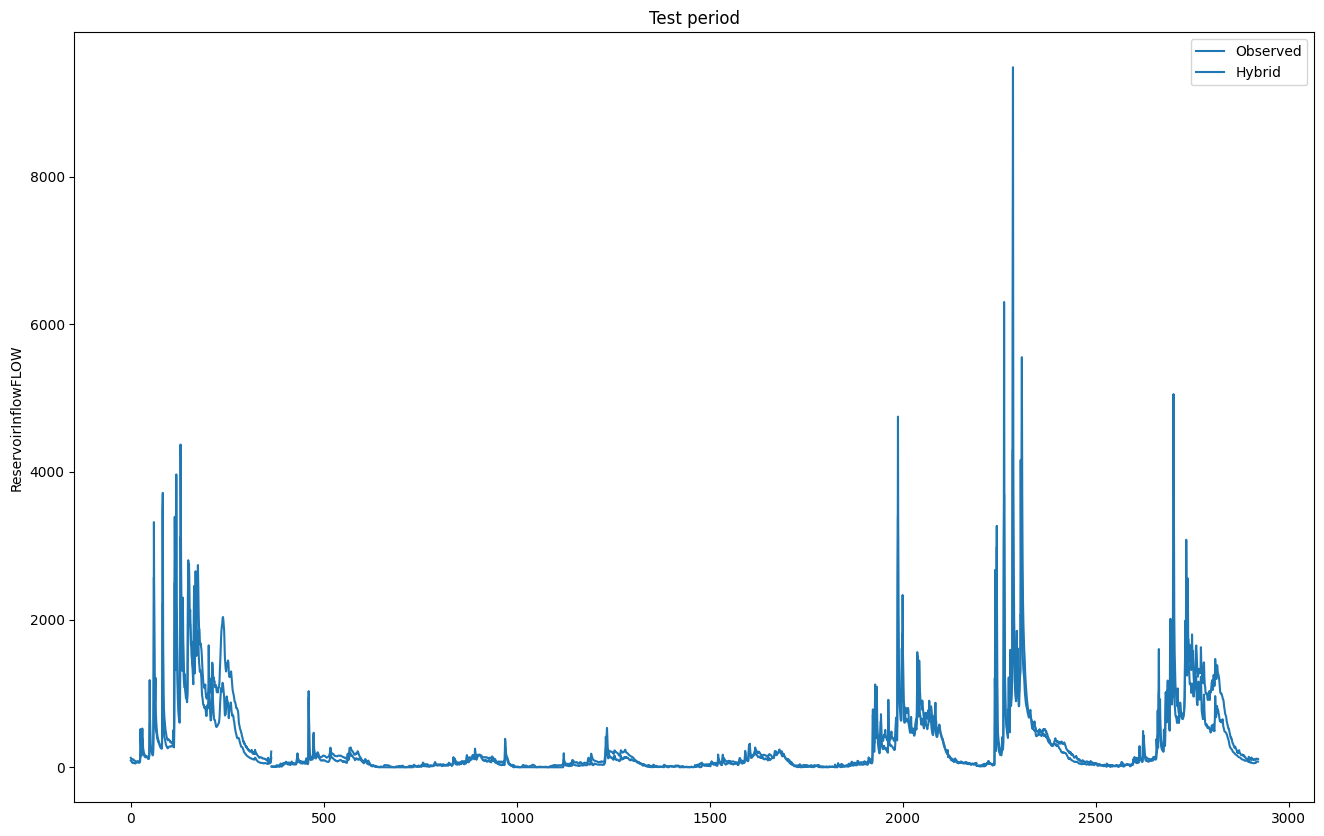

In [71]:
# extract observations and LSTM simulations
num_periods = concatonated_dfs['source'].iloc[-1] + 1

fig, ax = plt.subplots(figsize=(16,10))
for i in range(num_periods):
    period_df = concatonated_dfs[concatonated_dfs['source'] == i]
    
    obs_label = 'Observed' if i == 0 else None
    hybrid_label = 'Hybrid' if i == 0 else None
    HMS_label = 'HMS' if i == 0 else None
    print(period_df['DateTime'])
    obs_line = ax.plot(period_df.index, period_df['Observed'],  color='#1f77b4', label = obs_label)
    hybrid_line = ax.plot(period_df.index, period_df['LSTM_HMS'], color='#1f77b4', label = hybrid_label)
    #HMS_line = ax.plot(period_df['DateTime'], period_df['HMS'],label = HMS_label)

ax.set_ylabel("ReservoirInflowFLOW")
ax.legend()
ax.set_title(f"Test period");

In [24]:
dfs_dfs

,DateTime,Observed,LSTM_HMS,HMS,date
0,10/1/1982,120.929032,114.015004,67.645161,1982-10-01
1,11/1/1982,NaN,NaN,NaN,1982-11-01
2,12/1/1982,NaN,NaN,NaN,1982-12-01
3,1/1/1983,NaN,NaN,NaN,1983-01-01
4,2/1/1983,NaN,NaN,NaN,1983-02-01
...,...,...,...,...,...
91,5/1/1998,NaN,NaN,NaN,1998-05-01
92,6/1/1998,NaN,NaN,NaN,1998-06-01
93,7/1/1998,NaN,NaN,NaN,1998-07-01
94,8/1/1998,NaN,NaN,NaN,1998-08-01


In [99]:
def plot_discontinuous(path_to_csv):
    test_start_date = ['01/10/1982', '01/10/1987', '01/10/1989', '01/10/1991', '01/10/1993', '01/10/1994', '01/10/1996', '01/10/1997']
    test_end_date = ['30/09/1983', '30/09/1988', '30/09/1990', '30/09/1992', '30/09/1994', '30/09/1995', '30/09/1997', '30/09/1998']

    df = pd.read_csv(path_to_csv)
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    
    fig, axs = plt.subplots(nrows = 2, ncols=4, figsize=(60, 10))
    for i in range(len(test_start_date)):
        start_date = pd.to_datetime(test_start_date[i])
        end_date = pd.to_datetime(test_end_date[i])

        filtered_df = df[(df['DateTime'] >= start_date) & (df['DateTime'] <= end_date)]
        ax = axs[i // 4, i % 4]
        ax.plot(filtered_df['DateTime'], filtered_df['Observed'], label = "Observed")
        ax.plot(filtered_df['DateTime'], filtered_df['HMS'], label = "HMS")
        ax.plot(filtered_df['DateTime'], filtered_df['LSTM_HMS'], label = "Hybrid LSTM")
        ax.legend()
        if i in [0, 5, 6, 7]:
            ax.set_title('Extreme High')
        else:
            ax.set_title("Extreme Low")
    
    plt.show()

        


/var/folders/93/12rdf89j3ql6h5j8b_3g9ddm0000gn/T/ipykernel_92308/3615954480.py:11: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  end_date = pd.to_datetime(test_end_date[i])


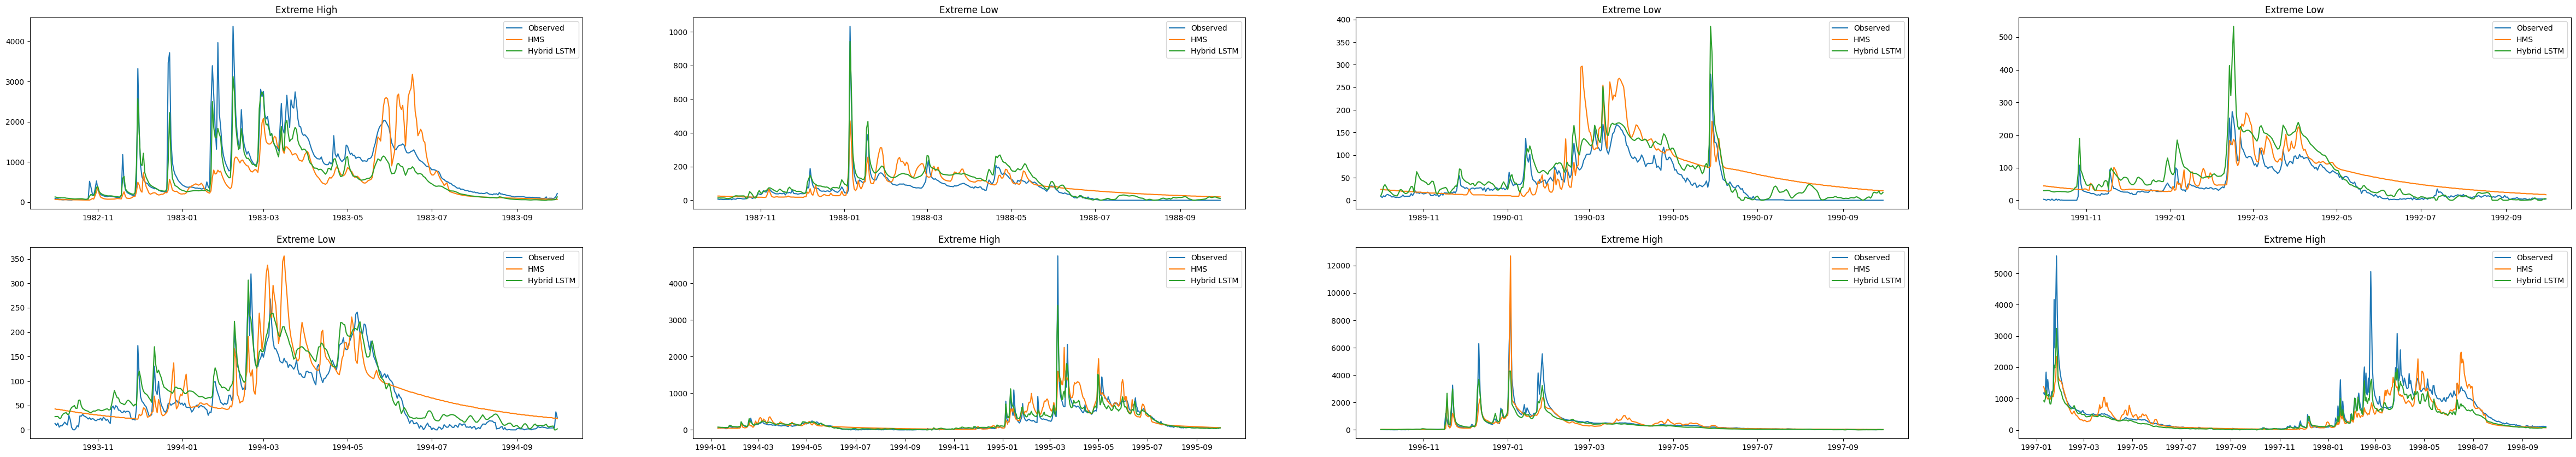

In [100]:
plot_discontinuous('/Users/evanrobert/Documents/ESDL_Research/Training_Data_3_Basins/presentation_plot_data/Inflow_daily_only_test_hard.csv')

In [59]:
# def plot_discontinuous_sameplot(path_to_csv):
#     test_start_date = ['01/10/1982', '01/10/1987', '01/10/1989', '01/10/1991', '01/10/1993', '01/10/1994', '01/10/1996', '01/10/1997']
#     test_end_date = ['30/09/1983', '30/09/1988', '30/09/1990', '30/09/1992', '30/09/1994', '30/09/1995', '30/09/1997', '30/09/1998']

#     df = pd.read_csv(path_to_csv)
#     df['DateTime'] = pd.to_datetime(df['DateTime'])
#     df['Include'] = np.zeros(df.shape[0])
    
#     for i in range(len(test_start_date)):

#         start_date = pd.to_datetime(test_start_date[i])
#         end_date = pd.to_datetime(test_end_date[i])


#         for index, row in df.iterrows():
#             if (row['DateTime'] >= start_date) and (row['DateTime'] <= end_date):
#                 df.at[index, 'Include'] = 1
#     for index, row in df.iterrows():
#         if row['Include'] == 0:
#             df.at[index, 'Observed'] = None
#             df.at[index, 'HMS'] = None
#             df.at[index, 'HMS_LSTM'] = None
#     return df

In [60]:
# df_discontinuous_sameplot = plot_discontinuous_sameplot('/Users/evanrobert/Documents/ESDL_Research/Training_Data_3_Basins/presentation_plot_data/Inflow_daily_only_test_hard.csv')

/var/folders/93/12rdf89j3ql6h5j8b_3g9ddm0000gn/T/ipykernel_95144/1221885454.py:12: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  end_date = pd.to_datetime(test_end_date[i])
/var/folders/93/12rdf89j3ql6h5j8b_3g9ddm0000gn/T/ipykernel_95144/1221885454.py:12: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  end_date = pd.to_datetime(test_end_date[i])
/var/folders/93/12rdf89j3ql6h5j8b_3g9ddm0000gn/T/ipykernel_95144/1221885454.py:12: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  end_date = pd.to_datetime(test_end_date[i])
/var/folders/93/12rdf89j3ql6h5j8b_3g9ddm0000gn/T/ipykernel_95144/1221885454.py:12: UserWarning: Parsing dates in %d/%m/%Y format w

In [61]:
# all(df_discontinuous_sameplot['Include'].values)

True

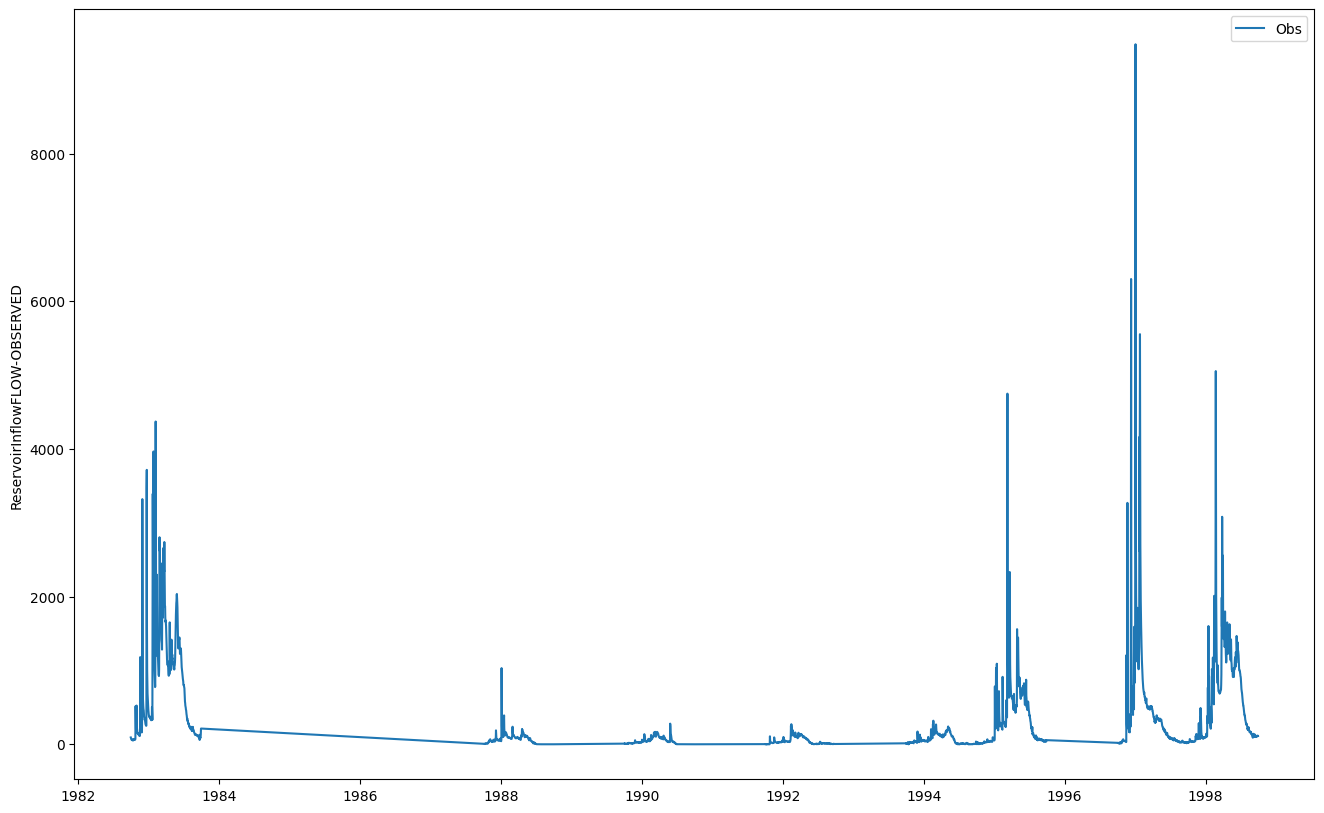

In [55]:
# fig, ax = plt.subplots(figsize=(16,10))
# ax.plot(df_discontinuous_sameplot["DateTime"], df_discontinuous_sameplot["Observed"], label="Obs")

# ax.set_ylabel("ReservoirInflowFLOW-OBSERVED")
# ax.legend()
# #ax.set_title(f"Train period - NSE {results['Tuler']['1D']['NSE']:.3f}")

### Peak metrics

In [12]:
test_hard = pd.read_csv('/Users/evanrobert/Documents/ESDL_Research/Training_Data_3_Basins/presentation_plot_data/Inflow_daily_only_test_hard.csv')
test_hard["date"] = pd.to_datetime(test_hard["DateTime"])


# matlab_lstm = matlab_lstm[['Date', 'LSTM-HMS']]

# start_date = '1981-10-01'
# end_date = '1982-09-30'

# # Filter the DataFrame to keep only the dates within the specified range
# matlab_lstm = matlab_lstm[(matlab_lstm['Date'] >= start_date) & (matlab_lstm['Date'] <= end_date)] -->

In [23]:
def get_metrics(filepath, startdate, enddate):
    test_hard = pd.read_csv(filepath)
    
    test_hard["date"] = pd.to_datetime(test_hard["DateTime"])
    test_hard = test_hard[(test_hard['date'] >= startdate) & (test_hard['date'] <= enddate)]
    obs = xr.DataArray(test_hard['Observed'].values, dims=['date'], coords={'date': test_hard['date']})
    sim = xr.DataArray(test_hard['LSTM_HMS'].values, dims=['date'], coords={'date': test_hard['date']})

    qobs = test_hard['Observed']
    qsim = test_hard['LSTM_HMS']

    fig, ax = plt.subplots(figsize=(16,10))
    ax.plot(test_hard["date"], qobs, label="Observed")
    ax.plot(test_hard["date"], qsim, label="HMS-LSTM")
    ax.set_ylabel("ReservoirInflowFLOW-OBSERVED")
    ax.legend();

    return calculate_all_metrics(obs, sim)

missed peaks: 2
num peaks: 4
missed peaks: 0
num peaks: 4


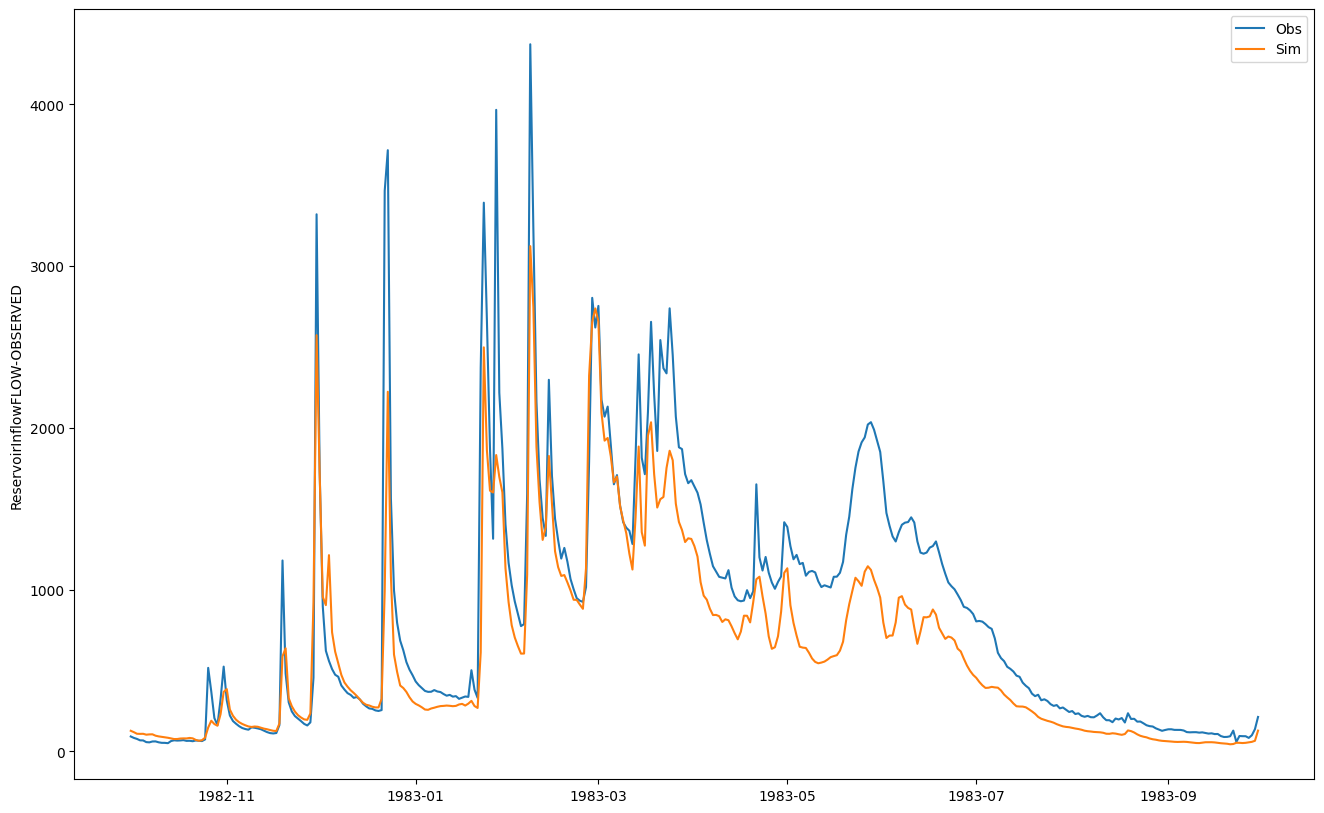

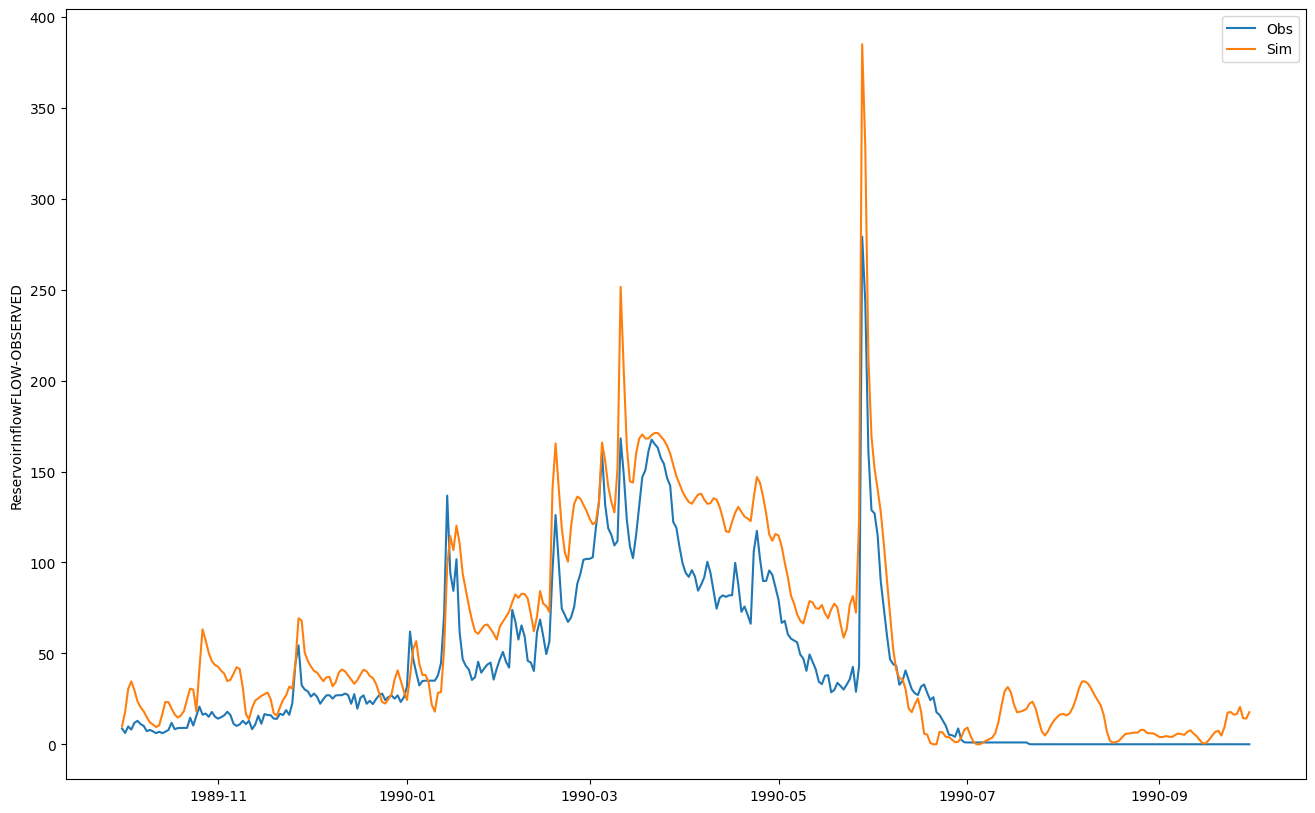

In [3]:
#hard_metrics = get_metrics('/Users/evanrobert/Documents/ESDL_Research/Training_Data_3_Basins/presentation_plot_data/Inflow_daily_only_test_hard.csv')
#easy_metrics = get_metrics('/Users/evanrobert/Documents/ESDL_Research/Training_Data_3_Basins/presentation_plot_data/Inflow_daily_only_test_easy.csv')

start_date = '1982-10-01'
end_date = '1983-09-30'

high_water_year_metrics = get_metrics('/Users/evanrobert/Documents/ESDL_Research/Training_Data_3_Basins/presentation_plot_data/Inflow_daily_only_test_hard.csv', start_date, end_date)


start_date = '1989-10-01'
end_date = '1990-09-30'

low_water_year_metrics = get_metrics('/Users/evanrobert/Documents/ESDL_Research/Training_Data_3_Basins/presentation_plot_data/Inflow_daily_only_test_hard.csv', start_date, end_date)

In [4]:
print(hard_metrics['Peak-Timing'])
print(hard_metrics['Peak-MAPE'])
print(hard_metrics['FHV'])

NameError: name 'hard_metrics' is not defined

In [5]:
easy_metrics

NameError: name 'easy_metrics' is not defined

missed peaks: 2
num peaks: 4
Peak Timing: 0.5
Peak MAPE: 36.70380355267621
Missed Peaks: 0.5
NSE: 0.7592221427046837
FHV: -25.4007543917121
FMV: -2.964667271314908
FLV: 15.341985247903589


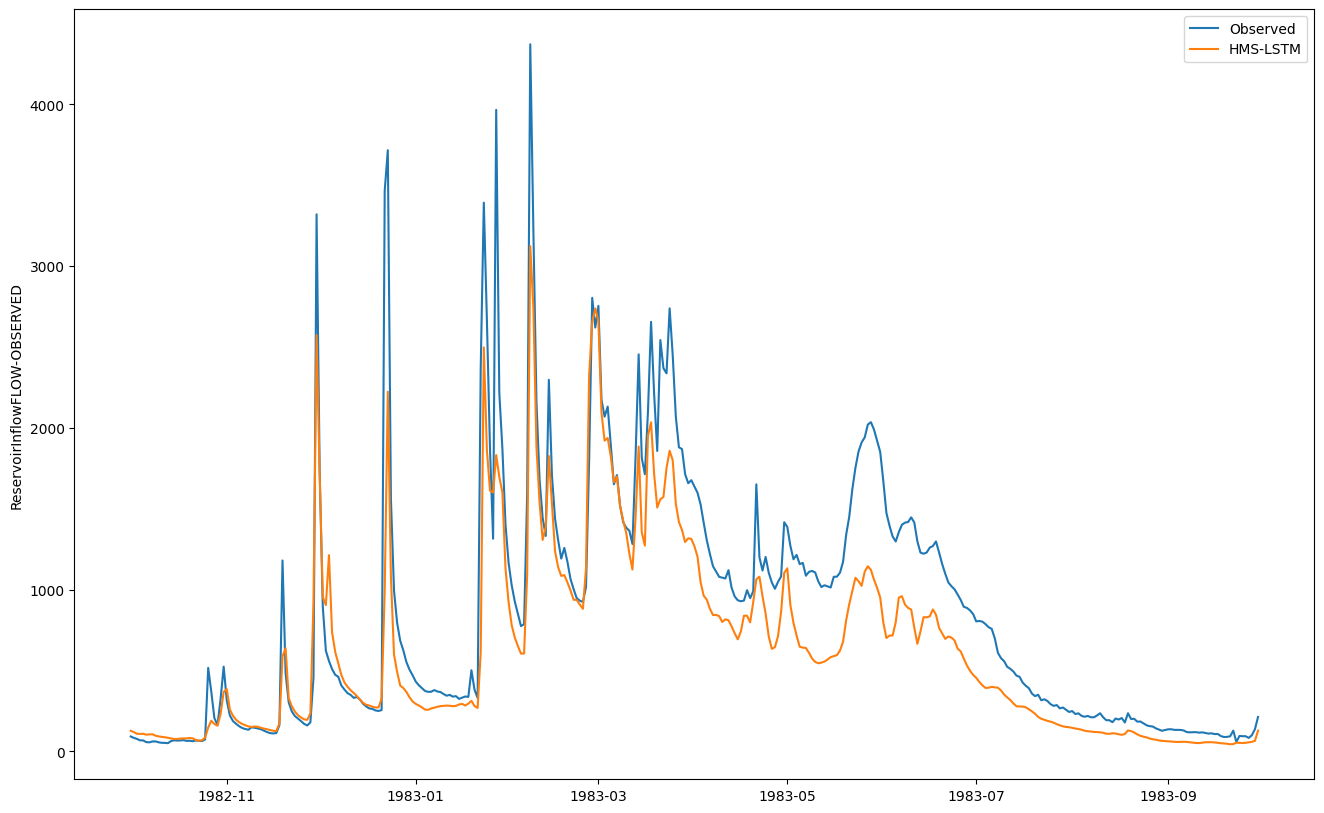

In [34]:
start_date = '1982-10-01'
end_date = '1983-09-30'
high_water_year_metrics = get_metrics('/Users/evanrobert/Documents/ESDL_Research/Training_Data_3_Basins/presentation_plot_data/Inflow_daily_only_test_hard.csv', start_date, end_date)

print(f"Peak Timing: {high_water_year_metrics['Peak-Timing']}")
#Mean difference in peak flow timing
print(f"Peak MAPE: {high_water_year_metrics['Peak-MAPE']}")
#mean_absolute_percentage_peak_error

#peak flow bias of the flow duration curve
print(f"Missed Peaks: {high_water_year_metrics['Missed-Peaks']}")
print(f"NSE: {high_water_year_metrics['NSE']}")
print(f"FHV: {high_water_year_metrics['FHV']}")
print(f"FMV: {high_water_year_metrics['FMS']}")
print(f"FLV: {high_water_year_metrics['FLV']}")

missed peaks: 0
num peaks: 4
Peak Timing: 1.5
Peak MAPE: 33.15388372425594
Missed Peaks: 0.0
NSE: 0.6831142225626625
FHV: 28.097351395647152
FMV: -18.941953676102518
FLV: -193.91324383595722


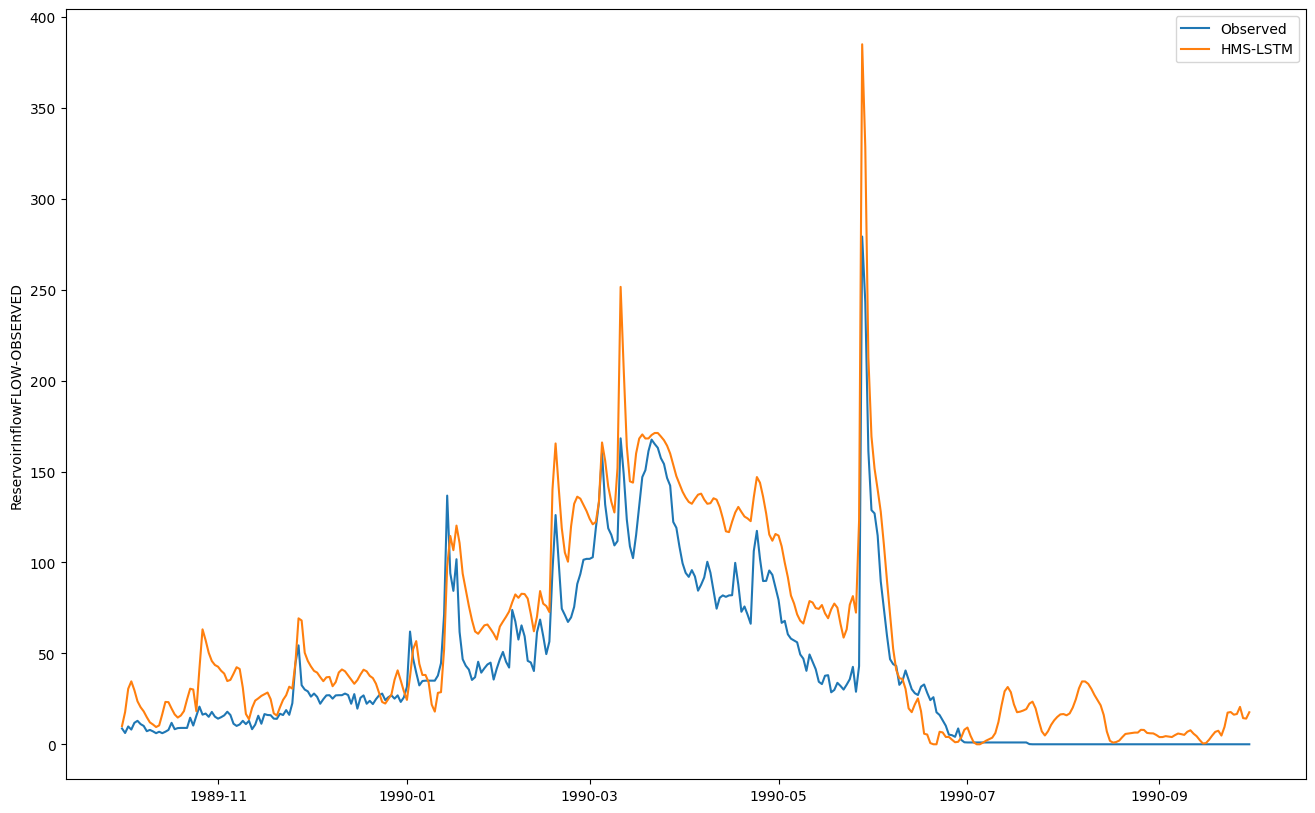

In [36]:
start_date = '1989-10-01'
end_date = '1990-09-30'

low_water_year_metrics = get_metrics('/Users/evanrobert/Documents/ESDL_Research/Training_Data_3_Basins/presentation_plot_data/Inflow_daily_only_test_hard.csv', start_date, end_date)
print(f"Peak Timing: {low_water_year_metrics['Peak-Timing']}")
print(f"Peak MAPE: {low_water_year_metrics['Peak-MAPE']}")
#print(f"FHV: {low_water_year_metrics['FHV']}")
print(f"Missed Peaks: {low_water_year_metrics['Missed-Peaks']}")
print(f"NSE: {low_water_year_metrics['NSE']}")
print(f"FHV: {low_water_year_metrics['FHV']}")
print(f"FMV: {low_water_year_metrics['FMS']}")
print(f"FLV: {low_water_year_metrics['FLV']}")


missed peaks: 1
num peaks: 4
Peak Timing: 2.0
Peak MAPE: 28.96492080879699
FHV: -4.943846721118892
Missed Peaks: 0.25
NSE: 0.8157715518470061


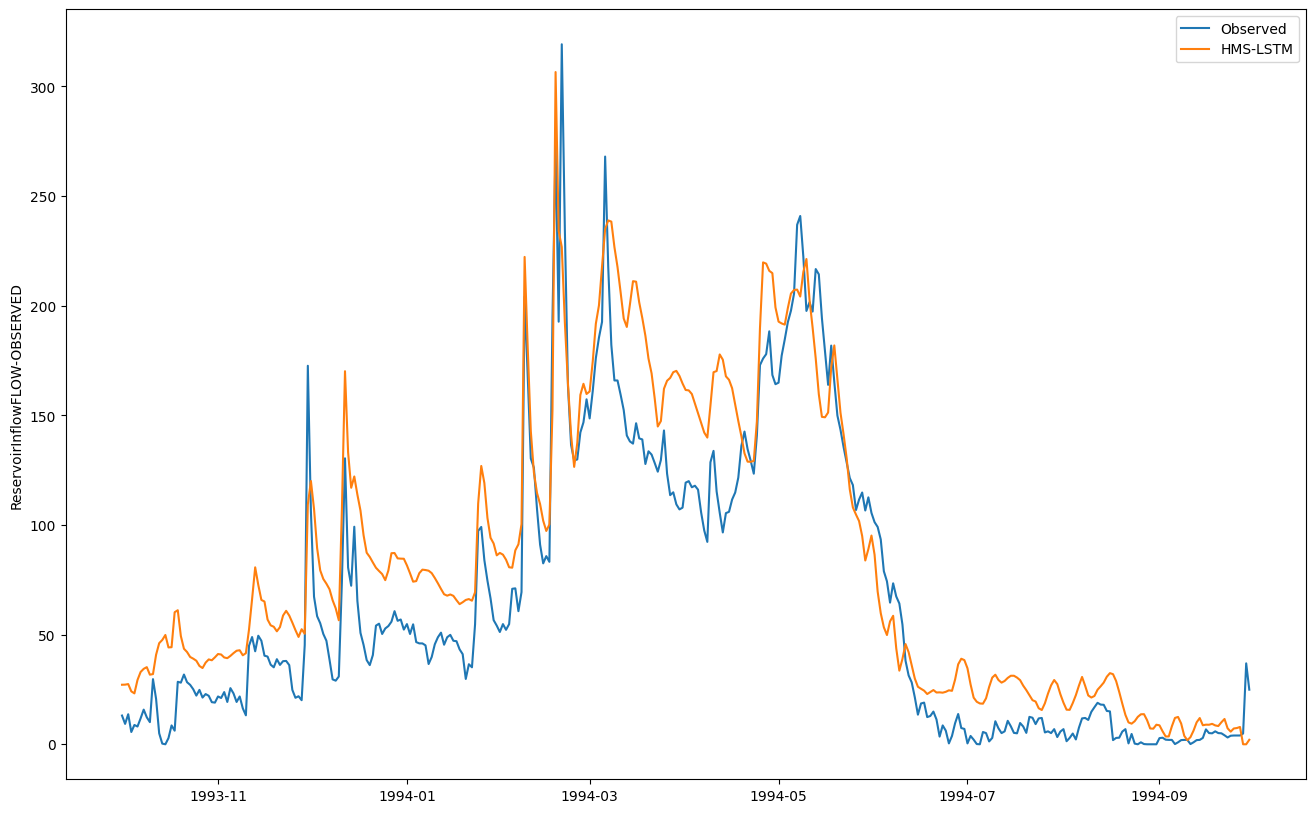

In [27]:
start_date = '1993-10-01'
end_date = '1994-09-30'

avg_water_year_metrics = get_metrics('/Users/evanrobert/Documents/ESDL_Research/Training_Data_3_Basins/presentation_plot_data/Inflow_daily_only_test_hard.csv', start_date, end_date)
print(f"Peak Timing: {avg_water_year_metrics['Peak-Timing']}")
print(f"Peak MAPE: {avg_water_year_metrics['Peak-MAPE']}")
print(f"FHV: {avg_water_year_metrics['FHV']}")
print(f"Missed Peaks: {avg_water_year_metrics['Missed-Peaks']}")
print(f"NSE: {avg_water_year_metrics['NSE']}")
